In [1]:
import os
import PIL
import numpy as np
from glob import glob
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, load_model, model_from_json, Model

In [2]:
from keras.models import Model
from keras.layers import Flatten, Dense, BatchNormalization, Dropout
from keras.applications import VGG16
from tensorflow.keras.regularizers import l2
#from keras.preprocessing import image
num_classes = 4

IMAGE_SIZE = [224, 224]  # we will keep the image size as (64,64). You can increase the size for better results. 

# loading the weights of VGG16 without the top layer. These weights are trained on Imagenet dataset.
vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)  # input_shape = (64,64,3) as required by VGG

# this will exclude the initial layers from training phase as there are already been trained.
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
x = BatchNormalization()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)                  # we can add a new fully connected layer but it will increase the execution time.
x = Dense(num_classes, activation = 'softmax')(x)  # adding the output layer with softmax function as this is a multi label classification problem.

model = Model(inputs = vgg.input, outputs = x)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

2023-12-06 21:09:24.654930: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-06 21:09:24.654964: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-06 21:09:24.654983: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-06 21:09:24.655029: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-06 21:09:24.655050: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
train_dir ='/Users/aayushrangra/Desktop/GrapeVine_Disease_Detection/custom_dataset/train'
valid_dir ='/Users/aayushrangra/Desktop/GrapeVine_Disease_Detection/custom_dataset/valid'
test_dir = '/Users/aayushrangra/Desktop/GrapeVine_Disease_Detection/custom_dataset/test'

num_classes = 4

In [8]:
IMAGE_SIZE = [224, 224]

train_gen = ImageDataGenerator(
    rescale=1./255
    )
val_gen = ImageDataGenerator(
    rescale=1./255
    )  
test_gen = ImageDataGenerator(
    rescale=1./255
    )


train_set = train_gen.flow_from_directory(
    train_dir,
    class_mode = 'categorical',
    target_size = IMAGE_SIZE,
    batch_size = 16
    )
val_set = val_gen.flow_from_directory(
    valid_dir,
    class_mode = 'categorical',
    target_size = IMAGE_SIZE,
    batch_size = 16
    )
test_set = test_gen.flow_from_directory(
    test_dir,
    class_mode = 'categorical',
    target_size = IMAGE_SIZE,
    batch_size = 16
)

Found 8400 images belonging to 4 classes.
Found 1800 images belonging to 4 classes.
Found 1800 images belonging to 4 classes.


In [9]:
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5),
    metrics=['accuracy']
    )

In [10]:
VGG_model = model.fit(
     train_set,
     validation_data=val_set, 
     epochs=10,
     steps_per_epoch = len(train_set),
     validation_steps = len(val_set),)

Epoch 1/10
525/525 [==============================] - 286s 539ms/step - loss: 3.1257 - accuracy: 0.7540 - val_loss: 2.4968 - val_accuracy: 0.9322
Epoch 2/10
525/525 [==============================] - 285s 543ms/step - loss: 2.5448 - accuracy: 0.8914 - val_loss: 2.2992 - val_accuracy: 0.9544
Epoch 3/10
525/525 [==============================] - 1107s 2s/step - loss: 2.3219 - accuracy: 0.9267 - val_loss: 2.1605 - val_accuracy: 0.9628
Epoch 4/10
525/525 [==============================] - 156s 296ms/step - loss: 2.1687 - accuracy: 0.9423 - val_loss: 2.0402 - val_accuracy: 0.9678
Epoch 5/10
525/525 [==============================] - 172s 328ms/step - loss: 2.0408 - accuracy: 0.9482 - val_loss: 1.9283 - val_accuracy: 0.9739
Epoch 6/10
525/525 [==============================] - 184s 350ms/step - loss: 1.9185 - accuracy: 0.9598 - val_loss: 1.8259 - val_accuracy: 0.9750
Epoch 7/10
525/525 [==============================] - 220s 420ms/step - loss: 1.8060 - accuracy: 0.9654 - val_loss: 1.7218 - v

In [11]:
VGG_model.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [12]:
acc = VGG_model.history['accuracy']
val_acc = VGG_model.history['val_accuracy']

loss = VGG_model.history['loss']
val_loss = VGG_model.history['val_loss']

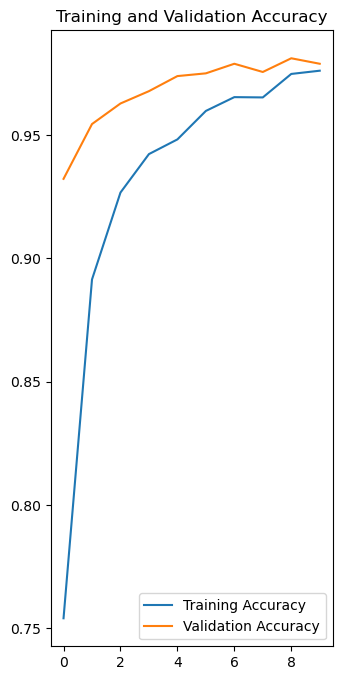

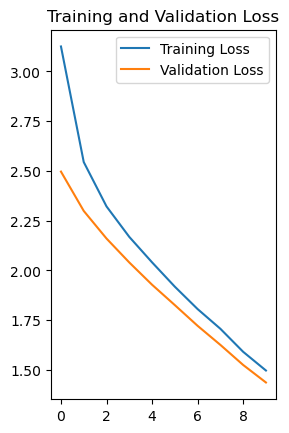

In [13]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(10), acc, label='Training Accuracy')
plt.plot(range(10), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()


plt.subplot(1, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
predictions = model.predict(test_set)

113/113 [==============================] - 44s 391ms/step


In [15]:
y_pred = np.argmax(predictions, axis=-1)

In [16]:
test_set.class_indices

{'Black Rot': 0, 'ESCA': 1, 'Healthy': 2, 'Leaf Blight': 3}

In [17]:
scores = model.evaluate(test_set, batch_size=16, verbose=2)

113/113 - 50s - loss: 1.4550 - accuracy: 0.9750 - 50s/epoch - 440ms/step
